# Time Series Forcasting using Tensorflow 2.0

## Setup

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [0]:
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [0]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

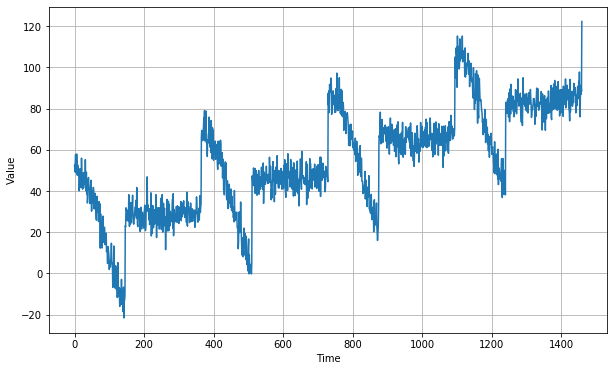

In [74]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

## Forecasting with Machine Learning

First, we will train a model to forecast the next step given the previous 20 steps, therefore, we need to create a dataset of 20-step windows for training.

In [0]:
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [0]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

### Linear Model

In [77]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
model.fit(train_set, epochs=100, validation_data=valid_set)

31/31 [==============================] - 0s 13ms/step - loss: 5.5149 - mae: 5.9983 - val_loss: 5.5693 - val_mae: 6.0602
Epoch 76/100
31/31 [==============================] - 0s 13ms/step - loss: 5.4193 - mae: 5.9415 - val_loss: 6.1903 - val_mae: 6.5490
Epoch 77/100
31/31 [==============================] - 0s 13ms/step - loss: 5.4517 - mae: 5.9418 - val_loss: 5.5656 - val_mae: 6.0782
Epoch 78/100
31/31 [==============================] - 0s 13ms/step - loss: 5.4377 - mae: 5.9419 - val_loss: 5.5060 - val_mae: 6.0019
Epoch 79/100
31/31 [==============================] - 0s 12ms/step - loss: 5.4014 - mae: 5.8664 - val_loss: 5.4817 - val_mae: 5.9891
Epoch 80/100
31/31 [==============================] - 0s 12ms/step - loss: 5.3910 - mae: 5.8161 - val_loss: 5.5085 - val_mae: 6.0166
Epoch 81/100
31/31 [==============================] - 0s 13ms/step - loss: 5.3114 - mae: 5.8146 - val_loss: 5.6281 - val_mae: 6.0466
Epoch 82/100
31/31 [==============================] - 0s 13ms/step - loss: 5.3286 

Epoch 1/100
31/31 [==============================] - 1s 26ms/step - loss: 46.6127 - mae: 47.9542 - val_loss: 22.8934 - val_mae: 23.3670
Epoch 2/100
31/31 [==============================] - 0s 13ms/step - loss: 11.5051 - mae: 11.9459 - val_loss: 9.2357 - val_mae: 9.6871
Epoch 3/100
31/31 [==============================] - 1s 31ms/step - loss: 9.8460 - mae: 10.3806 - val_loss: 9.1530 - val_mae: 9.6008
Epoch 4/100
31/31 [==============================] - 0s 13ms/step - loss: 9.7397 - mae: 10.2880 - val_loss: 9.2402 - val_mae: 9.5627
Epoch 5/100
31/31 [==============================] - 0s 13ms/step - loss: 9.6098 - mae: 10.1772 - val_loss: 8.8791 - val_mae: 9.4029
Epoch 6/100
31/31 [==============================] - 0s 14ms/step - loss: 9.5544 - mae: 10.0866 - val_loss: 8.9816 - val_mae: 9.3764
Epoch 7/100
31/31 [==============================] - 0s 13ms/step - loss: 9.5411 - mae: 9.9598 - val_loss: 9.1477 - val_mae: 9.6448
Epoch 8/100
31/31 [==============================] - 0s 13ms/step 

In [78]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 1s 19ms/step - loss: 67.5573 - mae: 68.2355
Epoch 2/100
31/31 [==============================] - 0s 11ms/step - loss: 52.3274 - mae: 52.8279
Epoch 3/100
31/31 [==============================] - 0s 8ms/step - loss: 34.6397 - mae: 35.3488
Epoch 4/100
31/31 [==============================] - 0s 9ms/step - loss: 17.6722 - mae: 18.2666
Epoch 5/100
31/31 [==============================] - 0s 9ms/step - loss: 8.4772 - mae: 9.0412
Epoch 6/100
31/31 [==============================] - 0s 9ms/step - loss: 7.9360 - mae: 8.4686
Epoch 7/100
31/31 [==============================] - 0s 9ms/step - loss: 8.0485 - mae: 8.3976
Epoch 8/100
31/31 [==============================] - 0s 9ms/step - loss: 7.8122 - mae: 8.3568
Epoch 9/100
31/31 [==============================] - 0s 9ms/step - loss: 7.8515 - mae: 8.3132
Epoch 10/100
31/31 [==============================] - 0s 9ms/step - loss: 7.8280 - mae: 8.2520
Epoch 11/100
31/31 [=============================

[1e-06, 0.001, 0, 20]

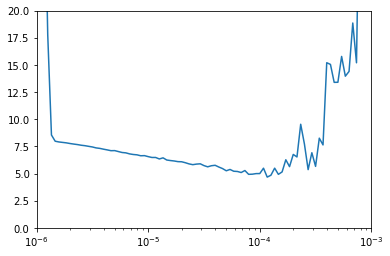

[1e-06, 0.001, 0, 20]

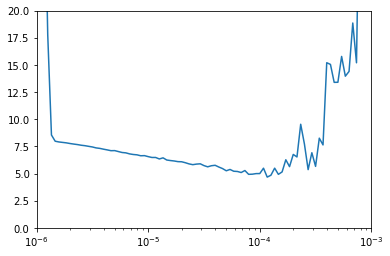

In [79]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1e-3, 0, 20])

In [80]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
31/31 [==============================] - 1s 27ms/step - loss: 46.6127 - mae: 47.9542 - val_loss: 22.8934 - val_mae: 23.3670
Epoch 2/500
31/31 [==============================] - 0s 14ms/step - loss: 11.5051 - mae: 11.9459 - val_loss: 9.2357 - val_mae: 9.6871
Epoch 3/500
31/31 [==============================] - 0s 12ms/step - loss: 9.8460 - mae: 10.3806 - val_loss: 9.1530 - val_mae: 9.6008
Epoch 4/500
31/31 [==============================] - 0s 13ms/step - loss: 9.7397 - mae: 10.2880 - val_loss: 9.2402 - val_mae: 9.5627
Epoch 5/500
31/31 [==============================] - 0s 13ms/step - loss: 9.6098 - mae: 10.1772 - val_loss: 8.8791 - val_mae: 9.4029
Epoch 6/500
31/31 [==============================] - 0s 12ms/step - loss: 9.5544 - mae: 10.0866 - val_loss: 8.9816 - val_mae: 9.3764
Epoch 7/500
31/31 [==============================] - 0s 13ms/step - loss: 9.5411 - mae: 9.9598 - val_loss: 9.1477 - val_mae: 9.6448
Epoch 8/500
31/31 [==============================] - 0s 13ms/step 

Epoch 1/500
31/31 [==============================] - 1s 28ms/step - loss: 46.6127 - mae: 47.9542 - val_loss: 22.8934 - val_mae: 23.3670
Epoch 2/500
31/31 [==============================] - 0s 13ms/step - loss: 11.5051 - mae: 11.9459 - val_loss: 9.2357 - val_mae: 9.6871
Epoch 3/500
31/31 [==============================] - 0s 13ms/step - loss: 9.8460 - mae: 10.3806 - val_loss: 9.1530 - val_mae: 9.6008
Epoch 4/500
31/31 [==============================] - 0s 14ms/step - loss: 9.7397 - mae: 10.2880 - val_loss: 9.2402 - val_mae: 9.5627
Epoch 5/500
31/31 [==============================] - 0s 13ms/step - loss: 9.6098 - mae: 10.1772 - val_loss: 8.8791 - val_mae: 9.4029
Epoch 6/500
31/31 [==============================] - 0s 14ms/step - loss: 9.5544 - mae: 10.0866 - val_loss: 8.9816 - val_mae: 9.3764
Epoch 7/500
31/31 [==============================] - 0s 13ms/step - loss: 9.5411 - mae: 9.9598 - val_loss: 9.1477 - val_mae: 9.6448
Epoch 8/500
31/31 [==============================] - 0s 13ms/step 

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [0]:
lin_forecast = model_forecast(model, series[split_time - window_size:-1], window_size)[:, 0]

In [83]:
lin_forecast.shape

(461,)

(461,)

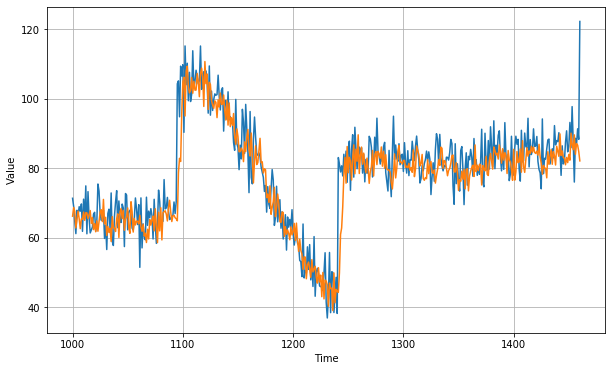

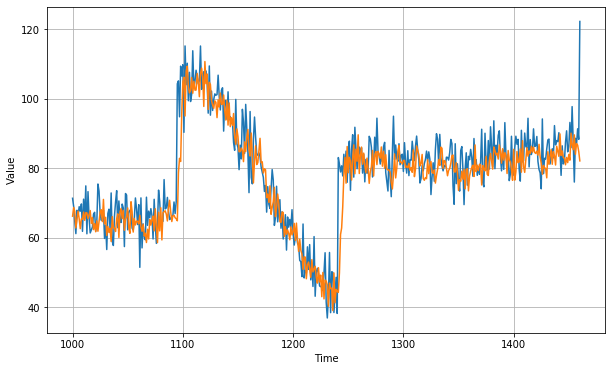

In [84]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, lin_forecast)

In [85]:
keras.metrics.mean_absolute_error(x_valid, lin_forecast).numpy()

5.3433857

5.3433857

### Dense Model Forecasting

In [86]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 1s 22ms/step - loss: 43.7565 - mae: 44.3312
Epoch 2/100
31/31 [==============================] - 0s 8ms/step - loss: 41.8288 - mae: 42.0073
Epoch 3/100
31/31 [==============================] - 0s 9ms/step - loss: 38.7457 - mae: 39.1402
Epoch 4/100
31/31 [==============================] - 0s 9ms/step - loss: 35.3772 - mae: 35.8227
Epoch 5/100
31/31 [==============================] - 0s 9ms/step - loss: 31.4448 - mae: 32.0831
Epoch 6/100
31/31 [==============================] - 0s 9ms/step - loss: 27.2989 - mae: 27.9021
Epoch 7/100
31/31 [==============================] - 0s 9ms/step - loss: 22.6964 - mae: 23.2716
Epoch 8/100
31/31 [==============================] - 0s 9ms/step - loss: 17.6484 - mae: 18.2723
Epoch 9/100
31/31 [==============================] - 0s 8ms/step - loss: 12.6114 - mae: 13.1545
Epoch 10/100
31/31 [==============================] - 0s 9ms/step - loss: 8.6302 - mae: 9.0650
Epoch 11/100
31/31 [====================

[1e-07, 0.005, 0, 30]

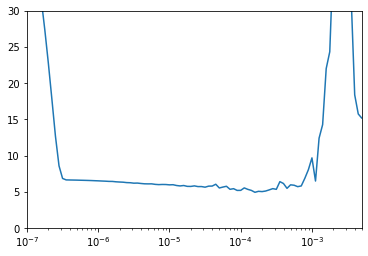

[1e-07, 0.005, 0, 30]

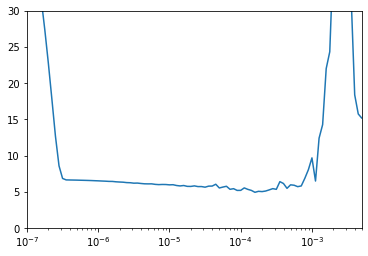

In [87]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 5e-3, 0, 30])

In [88]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
31/31 [==============================] - 1s 29ms/step - loss: 20.0335 - mae: 20.8270 - val_loss: 12.7604 - val_mae: 13.4040
Epoch 2/500
31/31 [==============================] - 0s 14ms/step - loss: 8.6268 - mae: 9.0442 - val_loss: 7.8260 - val_mae: 8.3112
Epoch 3/500
31/31 [==============================] - 0s 12ms/step - loss: 7.9271 - mae: 8.4718 - val_loss: 7.6869 - val_mae: 8.1423
Epoch 4/500
31/31 [==============================] - 0s 13ms/step - loss: 7.6027 - mae: 8.1519 - val_loss: 7.1338 - val_mae: 7.4683
Epoch 5/500
31/31 [==============================] - 0s 13ms/step - loss: 7.3532 - mae: 7.8994 - val_loss: 6.8095 - val_mae: 7.3306
Epoch 6/500
31/31 [==============================] - 0s 13ms/step - loss: 7.1958 - mae: 7.6983 - val_loss: 6.6906 - val_mae: 7.0048
Epoch 7/500
31/31 [==============================] - 0s 14ms/step - loss: 7.0248 - mae: 7.5004 - val_loss: 6.5143 - val_mae: 7.0573
Epoch 8/500
31/31 [==============================] - 0s 12ms/step - loss

Epoch 1/500
31/31 [==============================] - 1s 30ms/step - loss: 20.0335 - mae: 20.8270 - val_loss: 12.7604 - val_mae: 13.4040
Epoch 2/500
31/31 [==============================] - 0s 13ms/step - loss: 8.6268 - mae: 9.0442 - val_loss: 7.8260 - val_mae: 8.3112
Epoch 3/500
31/31 [==============================] - 0s 13ms/step - loss: 7.9271 - mae: 8.4718 - val_loss: 7.6869 - val_mae: 8.1423
Epoch 4/500
31/31 [==============================] - 0s 13ms/step - loss: 7.6027 - mae: 8.1519 - val_loss: 7.1338 - val_mae: 7.4683
Epoch 5/500
31/31 [==============================] - 0s 14ms/step - loss: 7.3532 - mae: 7.8994 - val_loss: 6.8095 - val_mae: 7.3306
Epoch 6/500
31/31 [==============================] - 0s 13ms/step - loss: 7.1958 - mae: 7.6983 - val_loss: 6.6906 - val_mae: 7.0048
Epoch 7/500
31/31 [==============================] - 0s 14ms/step - loss: 7.0248 - mae: 7.5004 - val_loss: 6.5143 - val_mae: 7.0573
Epoch 8/500
31/31 [==============================] - 0s 13ms/step - loss

In [0]:
dense_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

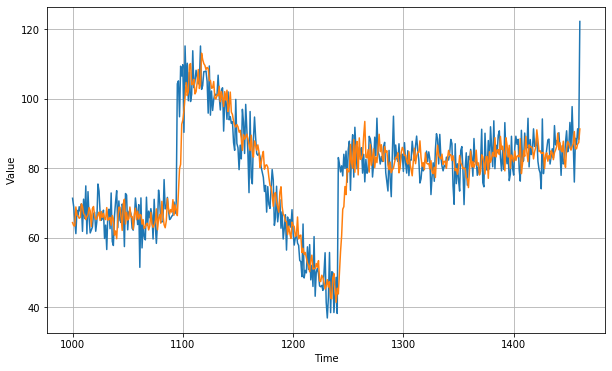

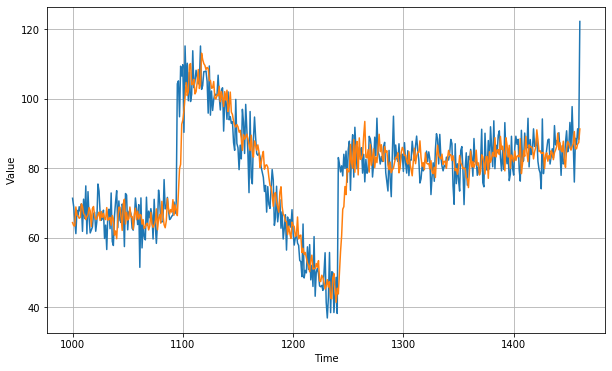

In [90]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, dense_forecast)

In [91]:
keras.metrics.mean_absolute_error(x_valid, dense_forecast).numpy()

5.299474

5.299474

## Simple RNN Forecasting

In [92]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 2s 219ms/step - loss: 49.6374 - mae: 50.8966
Epoch 2/100
8/8 [==============================] - 1s 67ms/step - loss: 22.8817 - mae: 23.2030
Epoch 3/100
8/8 [==============================] - 1s 69ms/step - loss: 19.4102 - mae: 19.5125
Epoch 4/100
8/8 [==============================] - 1s 68ms/step - loss: 16.8363 - mae: 17.3120
Epoch 5/100
8/8 [==============================] - 1s 73ms/step - loss: 15.6861 - mae: 16.1971
Epoch 6/100
8/8 [==============================] - 1s 71ms/step - loss: 15.1294 - mae: 15.5585
Epoch 7/100
8/8 [==============================] - 1s 73ms/step - loss: 14.5319 - mae: 14.9520
Epoch 8/100
8/8 [==============================] - 1s 70ms/step - loss: 14.0056 - mae: 14.6318
Epoch 9/100
8/8 [==============================] - 1s 72ms/step - loss: 13.6949 - mae: 14.4190
Epoch 10/100
8/8 [==============================] - 1s 69ms/step - loss: 13.4131 - mae: 14.0410
Epoch 11/100
8/8 [==============================

[1e-07, 0.0001, 0, 30]

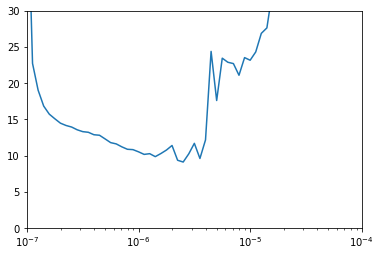

[1e-07, 0.0001, 0, 30]

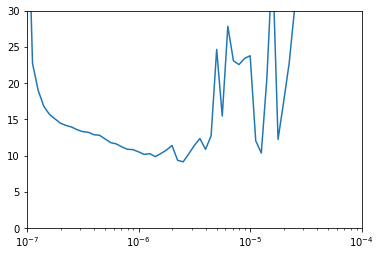

In [93]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [94]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)
valid_set = window_dataset(x_valid, window_size, batch_size=128)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1.5e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
8/8 [==============================] - 2s 295ms/step - loss: 59.3020 - mae: 60.3561 - val_loss: 42.0142 - val_mae: 42.3810
Epoch 2/500
8/8 [==============================] - 1s 88ms/step - loss: 36.5803 - mae: 37.3106 - val_loss: 11.4775 - val_mae: 11.7886
Epoch 3/500
8/8 [==============================] - 1s 87ms/step - loss: 23.6567 - mae: 24.0715 - val_loss: 12.7571 - val_mae: 13.0818
Epoch 4/500
8/8 [==============================] - 1s 88ms/step - loss: 16.7817 - mae: 17.6511 - val_loss: 21.4765 - val_mae: 22.3447
Epoch 5/500
8/8 [==============================] - 1s 82ms/step - loss: 13.7011 - mae: 14.3758 - val_loss: 10.0938 - val_mae: 10.6566
Epoch 6/500
8/8 [==============================] - 1s 82ms/step - loss: 11.4010 - mae: 12.0649 - val_loss: 11.5668 - val_mae: 12.0477
Epoch 7/500
8/8 [==============================] - 1s 86ms/step - loss: 11.0705 - mae: 11.4645 - val_loss: 8.4022 - val_mae: 8.9583
Epoch 8/500
8/8 [==============================] - 1s 89ms/step

Epoch 1/500
8/8 [==============================] - 2s 282ms/step - loss: 59.3019 - mae: 60.3561 - val_loss: 42.0143 - val_mae: 42.3810
Epoch 2/500
8/8 [==============================] - 1s 95ms/step - loss: 36.5803 - mae: 37.3106 - val_loss: 11.4775 - val_mae: 11.7886
Epoch 3/500
8/8 [==============================] - 1s 84ms/step - loss: 23.6567 - mae: 24.0715 - val_loss: 12.7571 - val_mae: 13.0818
Epoch 4/500
8/8 [==============================] - 1s 89ms/step - loss: 16.7817 - mae: 17.6511 - val_loss: 21.4765 - val_mae: 22.3447
Epoch 5/500
8/8 [==============================] - 1s 87ms/step - loss: 13.7011 - mae: 14.3758 - val_loss: 10.0939 - val_mae: 10.6566
Epoch 6/500
8/8 [==============================] - 1s 84ms/step - loss: 11.4010 - mae: 12.0649 - val_loss: 11.5667 - val_mae: 12.0477
Epoch 7/500
8/8 [==============================] - 1s 87ms/step - loss: 11.0705 - mae: 11.4645 - val_loss: 8.4022 - val_mae: 8.9582
Epoch 8/500
8/8 [==============================] - 1s 89ms/step

In [0]:
model = keras.models.load_model("my_checkpoint.h5")

In [0]:
rnn_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

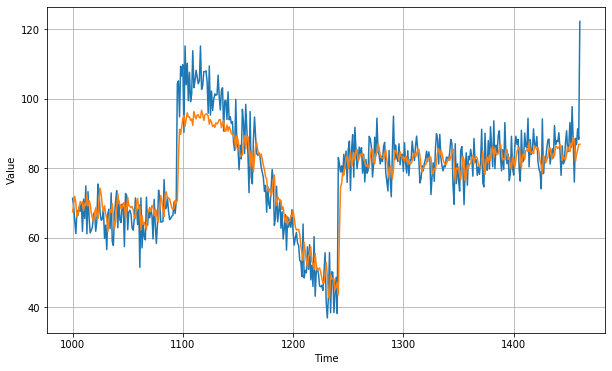

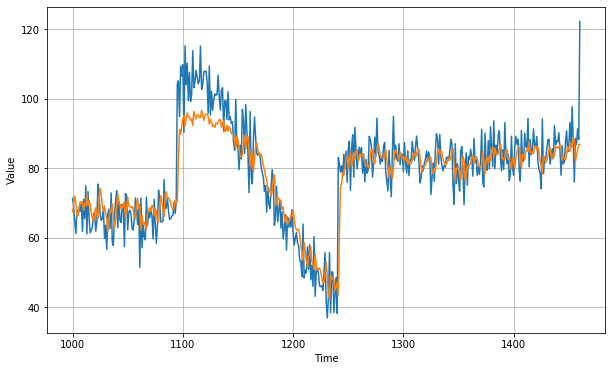

In [97]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [98]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.414171

5.414169

## Sequence-to-Sequence Forecasting

In [0]:
def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [100]:
for X_batch, Y_batch in seq2seq_window_dataset(tf.range(10), 3,
                                               batch_size=1):
    print("X:", X_batch.numpy())
    print("Y:", Y_batch.numpy())

X: [[[1]
  [2]
  [3]]]
Y: [[[2]
  [3]
  [4]]]
X: [[[2]
  [3]
  [4]]]
Y: [[[3]
  [4]
  [5]]]
X: [[[4]
  [5]
  [6]]]
Y: [[[5]
  [6]
  [7]]]
X: [[[3]
  [4]
  [5]]]
Y: [[[4]
  [5]
  [6]]]
X: [[[5]
  [6]
  [7]]]
Y: [[[6]
  [7]
  [8]]]
X: [[[6]
  [7]
  [8]]]
Y: [[[7]
  [8]
  [9]]]
X: [[[0]
  [1]
  [2]]]
Y: [[[1]
  [2]
  [3]]]
X: [[[1]
  [2]
  [3]]]
Y: [[[2]
  [3]
  [4]]]
X: [[[2]
  [3]
  [4]]]
Y: [[[3]
  [4]
  [5]]]
X: [[[4]
  [5]
  [6]]]
Y: [[[5]
  [6]
  [7]]]
X: [[[3]
  [4]
  [5]]]
Y: [[[4]
  [5]
  [6]]]
X: [[[5]
  [6]
  [7]]]
Y: [[[6]
  [7]
  [8]]]
X: [[[6]
  [7]
  [8]]]
Y: [[[7]
  [8]
  [9]]]
X: [[[0]
  [1]
  [2]]]
Y: [[[1]
  [2]
  [3]]]


In [101]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 2s 231ms/step - loss: 51.8012 - mae: 53.0833
Epoch 2/100
8/8 [==============================] - 1s 68ms/step - loss: 25.6187 - mae: 25.9613
Epoch 3/100
8/8 [==============================] - 1s 73ms/step - loss: 23.2629 - mae: 23.7153
Epoch 4/100
8/8 [==============================] - 1s 71ms/step - loss: 20.7639 - mae: 21.3966
Epoch 5/100
8/8 [==============================] - 1s 69ms/step - loss: 19.3458 - mae: 19.9318
Epoch 6/100
8/8 [==============================] - 1s 71ms/step - loss: 18.7027 - mae: 19.1986
Epoch 7/100
8/8 [==============================] - 1s 72ms/step - loss: 18.1732 - mae: 18.6635
Epoch 8/100
8/8 [==============================] - 1s 74ms/step - loss: 17.6910 - mae: 18.2660
Epoch 9/100
8/8 [==============================] - 1s 71ms/step - loss: 17.3617 - mae: 17.9216
Epoch 10/100
8/8 [==============================] - 1s 70ms/step - loss: 16.9487 - mae: 17.5786
Epoch 11/100
8/8 [==============================

[1e-07, 0.0001, 0, 30]

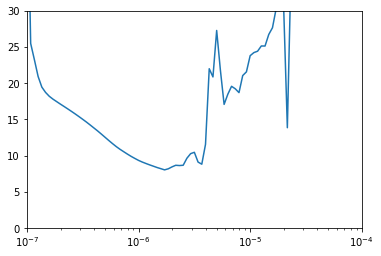

[1e-07, 0.0001, 0, 30]

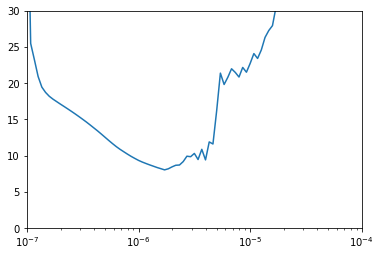

In [102]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [103]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
8/8 [==============================] - 2s 307ms/step - loss: 55.8513 - mae: 56.2826 - val_loss: 17.6785 - val_mae: 18.0197
Epoch 2/500
8/8 [==============================] - 1s 87ms/step - loss: 33.9155 - mae: 35.1114 - val_loss: 17.4471 - val_mae: 18.0774
Epoch 3/500
8/8 [==============================] - 1s 86ms/step - loss: 28.3637 - mae: 28.6514 - val_loss: 35.8525 - val_mae: 36.0964
Epoch 4/500
8/8 [==============================] - 1s 84ms/step - loss: 21.0046 - mae: 21.6919 - val_loss: 27.8289 - val_mae: 28.4824
Epoch 5/500
8/8 [==============================] - 1s 88ms/step - loss: 17.9119 - mae: 18.5032 - val_loss: 17.8702 - val_mae: 18.4260
Epoch 6/500
8/8 [==============================] - 1s 79ms/step - loss: 15.3045 - mae: 15.8192 - val_loss: 10.6281 - val_mae: 11.1624
Epoch 7/500
8/8 [==============================] - 1s 92ms/step - loss: 13.8782 - mae: 14.3735 - val_loss: 8.7739 - val_mae: 9.2796
Epoch 8/500
8/8 [==============================] - 1s 89ms/step

Epoch 1/500
8/8 [==============================] - 2s 286ms/step - loss: 55.8513 - mae: 56.2826 - val_loss: 17.6785 - val_mae: 18.0197
Epoch 2/500
8/8 [==============================] - 1s 89ms/step - loss: 33.9155 - mae: 35.1114 - val_loss: 17.4471 - val_mae: 18.0774
Epoch 3/500
8/8 [==============================] - 1s 88ms/step - loss: 28.3637 - mae: 28.6514 - val_loss: 35.8525 - val_mae: 36.0964
Epoch 4/500
8/8 [==============================] - 1s 84ms/step - loss: 21.0046 - mae: 21.6919 - val_loss: 27.8289 - val_mae: 28.4824
Epoch 5/500
8/8 [==============================] - 1s 87ms/step - loss: 17.9119 - mae: 18.5032 - val_loss: 17.8702 - val_mae: 18.4260
Epoch 6/500
8/8 [==============================] - 1s 89ms/step - loss: 15.3045 - mae: 15.8192 - val_loss: 10.6281 - val_mae: 11.1624
Epoch 7/500
8/8 [==============================] - 1s 86ms/step - loss: 13.8782 - mae: 14.3735 - val_loss: 8.7739 - val_mae: 9.2796
Epoch 8/500
8/8 [==============================] - 1s 89ms/step

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

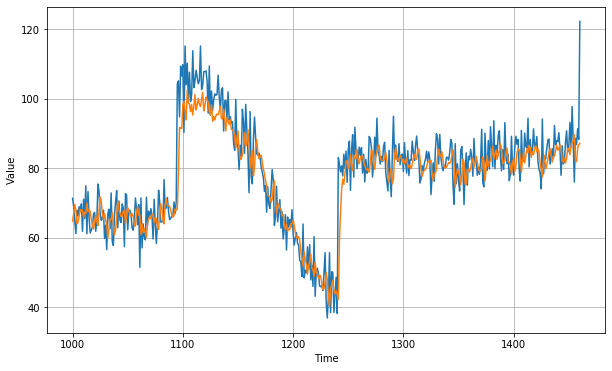

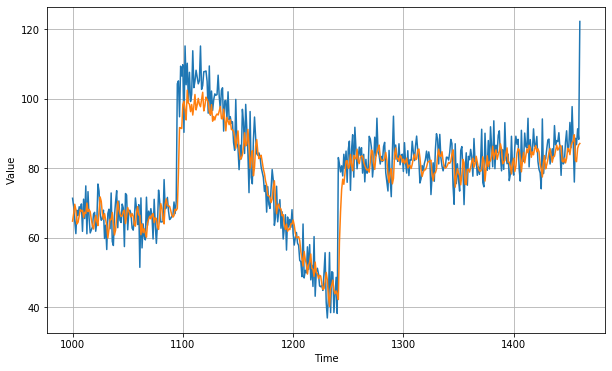

In [105]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [106]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.133628

5.1336308

## Stateful RNN Forecasting

In [0]:
def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

In [108]:
for X_batch, y_batch in sequential_window_dataset(tf.range(10), 3):
    print(X_batch.numpy(), y_batch.numpy())

[[[0]
  [1]
  [2]]] [[[1]
  [2]
  [3]]]
[[[3]
  [4]
  [5]]] [[[4]
  [5]
  [6]]]
[[[6]
  [7]
  [8]]] [[[7]
  [8]
  [9]]]
[[[0]
  [1]
  [2]]] [[[1]
  [2]
  [3]]]
[[[3]
  [4]
  [5]]] [[[4]
  [5]
  [6]]]
[[[6]
  [7]
  [8]]] [[[7]
  [8]
  [9]]]


In [0]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [40]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 30))
reset_states = ResetStatesCallback()
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

Epoch 1/100
33/33 [==============================] - 3s 81ms/step - loss: 105.9340 - mae: 106.4340
Epoch 2/100
33/33 [==============================] - 1s 42ms/step - loss: 70.8572 - mae: 71.3572
Epoch 3/100
33/33 [==============================] - 1s 42ms/step - loss: 39.8080 - mae: 40.3048
Epoch 4/100
33/33 [==============================] - 1s 42ms/step - loss: 27.3450 - mae: 27.8404
Epoch 5/100
33/33 [==============================] - 1s 41ms/step - loss: 24.4956 - mae: 24.9892
Epoch 6/100
33/33 [==============================] - 1s 43ms/step - loss: 23.2601 - mae: 23.7517
Epoch 7/100
33/33 [==============================] - 1s 44ms/step - loss: 22.0604 - mae: 22.5533
Epoch 8/100
33/33 [==============================] - 1s 41ms/step - loss: 20.8543 - mae: 21.3463
Epoch 9/100
33/33 [==============================] - 1s 41ms/step - loss: 19.8307 - mae: 20.3245
Epoch 10/100
33/33 [==============================] - 1s 43ms/step - loss: 18.9399 - mae: 19.4319
Epoch 11/100
33/33 [=======

[1e-08, 0.0001, 0, 30]

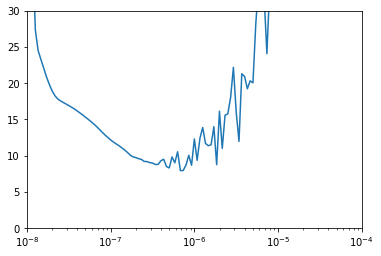

In [41]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [42]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500
33/33 [==============================] - 3s 94ms/step - loss: 60.2499 - mae: 60.7478 - val_loss: 25.0218 - val_mae: 25.5179
Epoch 2/500
33/33 [==============================] - 2s 47ms/step - loss: 21.4714 - mae: 21.9618 - val_loss: 10.9142 - val_mae: 11.4074
Epoch 3/500
33/33 [==============================] - 2s 47ms/step - loss: 18.7249 - mae: 19.2166 - val_loss: 12.0569 - val_mae: 12.5479
Epoch 4/500
33/33 [==============================] - 2s 47ms/step - loss: 17.5231 - mae: 18.0143 - val_loss: 10.4488 - val_mae: 10.9391
Epoch 5/500
33/33 [==============================] - 2s 47ms/step - loss: 16.6983 - mae: 17.1891 - val_loss: 9.9581 - val_mae: 10.4500
Epoch 6/500
33/33 [==============================] - 2s 47ms/step - loss: 15.9090 - mae: 16.3984 - val_loss: 9.1539 - val_mae: 9.6415
Epoch 7/500
33/33 [==============================] - 2s 47ms/step - loss: 15.2155 - mae: 15.7027 - val_loss: 8.3393 - val_mae: 8.8249
Epoch 8/500
33/33 [==============================] - 

In [0]:
model = keras.models.load_model("my_checkpoint.h5")

In [0]:
model.reset_states()
rnn_forecast = model.predict(series[np.newaxis, :, np.newaxis])
rnn_forecast = rnn_forecast[0, split_time - 1:-1, 0]

In [45]:
rnn_forecast.shape

(461,)

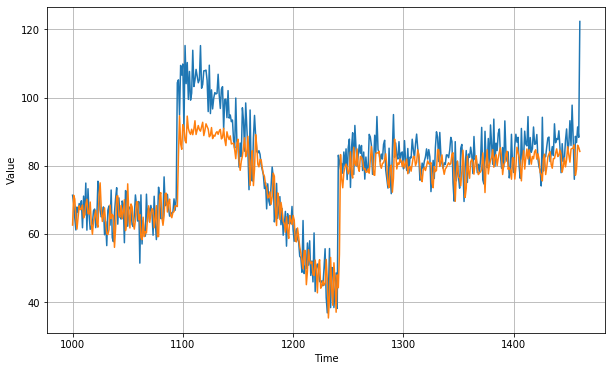

In [46]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [47]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

6.2778373

## LSTM RNN Forecasting

In [0]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [49]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                    batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
reset_states = ResetStatesCallback()
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

Epoch 1/100
33/33 [==============================] - 5s 159ms/step - loss: 90.9191 - mae: 91.4191
Epoch 2/100
33/33 [==============================] - 0s 14ms/step - loss: 83.8978 - mae: 84.3978
Epoch 3/100
33/33 [==============================] - 0s 14ms/step - loss: 75.4974 - mae: 75.9974
Epoch 4/100
33/33 [==============================] - 0s 14ms/step - loss: 66.0676 - mae: 66.5676
Epoch 5/100
33/33 [==============================] - 0s 14ms/step - loss: 55.5131 - mae: 56.0131
Epoch 6/100
33/33 [==============================] - 0s 14ms/step - loss: 43.7599 - mae: 44.2597
Epoch 7/100
33/33 [==============================] - 0s 14ms/step - loss: 30.7909 - mae: 31.2900
Epoch 8/100
33/33 [==============================] - 0s 13ms/step - loss: 17.1478 - mae: 17.6436
Epoch 9/100
33/33 [==============================] - 0s 14ms/step - loss: 10.0311 - mae: 10.5178
Epoch 10/100
33/33 [==============================] - 0s 13ms/step - loss: 10.0607 - mae: 10.5524
Epoch 11/100
33/33 [========

[1e-08, 0.0001, 0, 30]

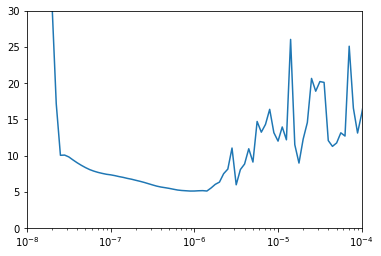

In [50]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [51]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=5e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500
33/33 [==============================] - 3s 102ms/step - loss: 30.0122 - mae: 30.5050 - val_loss: 13.0810 - val_mae: 13.5746
Epoch 2/500
33/33 [==============================] - 1s 18ms/step - loss: 15.3618 - mae: 15.8570 - val_loss: 10.0991 - val_mae: 10.5941
Epoch 3/500
33/33 [==============================] - 1s 17ms/step - loss: 10.9284 - mae: 11.4173 - val_loss: 11.2192 - val_mae: 11.7083
Epoch 4/500
33/33 [==============================] - 1s 17ms/step - loss: 9.8165 - mae: 10.3052 - val_loss: 12.2806 - val_mae: 12.7757
Epoch 5/500
33/33 [==============================] - 1s 17ms/step - loss: 7.8424 - mae: 8.3317 - val_loss: 9.6437 - val_mae: 10.1336
Epoch 6/500
33/33 [==============================] - 1s 17ms/step - loss: 7.1708 - mae: 7.6561 - val_loss: 10.6124 - val_mae: 11.1036
Epoch 7/500
33/33 [==============================] - 1s 17ms/step - loss: 5.9200 - mae: 6.4041 - val_loss: 10.1595 - val_mae: 10.6522
Epoch 8/500
33/33 [==============================] - 1s

In [0]:
model = keras.models.load_model("my_checkpoint.h5")

In [0]:
rnn_forecast = model.predict(series[np.newaxis, :, np.newaxis])
rnn_forecast = rnn_forecast[0, split_time - 1:-1, 0]

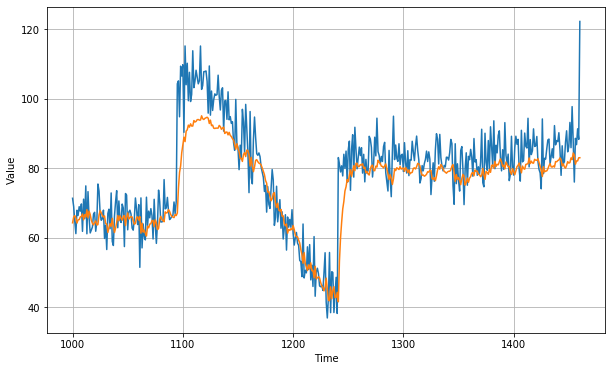

In [54]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [55]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.907986

## Preprocessing With 1D-Convolutional Layers

In [56]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 3s 371ms/step - loss: 87.5326 - mae: 88.3356
Epoch 2/100
8/8 [==============================] - 0s 35ms/step - loss: 87.2754 - mae: 87.6112
Epoch 3/100
8/8 [==============================] - 0s 32ms/step - loss: 85.8511 - mae: 86.4322
Epoch 4/100
8/8 [==============================] - 0s 34ms/step - loss: 84.3254 - mae: 84.8714
Epoch 5/100
8/8 [==============================] - 0s 34ms/step - loss: 82.4993 - mae: 82.9793
Epoch 6/100
8/8 [==============================] - 0s 34ms/step - loss: 80.0619 - mae: 80.7489
Epoch 7/100
8/8 [==============================] - 0s 31ms/step - loss: 77.7010 - mae: 78.2492
Epoch 8/100
8/8 [==============================] - 0s 32ms/step - loss: 75.0298 - mae: 75.6000
Epoch 9/100
8/8 [==============================] - 0s 38ms/step - loss: 72.5263 - mae: 72.9481
Epoch 10/100
8/8 [==============================] - 0s 37ms/step - loss: 69.8746 - mae: 70.4036
Epoch 11/100
8/8 [==============================

[1e-08, 0.0001, 0, 30]

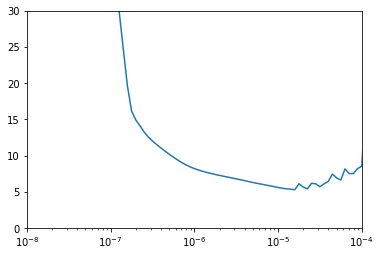

In [57]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [58]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
8/8 [==============================] - 4s 483ms/step - loss: 57.2245 - mae: 58.2706 - val_loss: 24.8499 - val_mae: 25.2737
Epoch 2/500
8/8 [==============================] - 0s 49ms/step - loss: 23.6080 - mae: 24.3364 - val_loss: 35.8343 - val_mae: 36.9375
Epoch 3/500
8/8 [==============================] - 0s 47ms/step - loss: 16.6442 - mae: 17.2362 - val_loss: 37.3008 - val_mae: 37.5001
Epoch 4/500
8/8 [==============================] - 0s 52ms/step - loss: 13.8302 - mae: 14.3808 - val_loss: 22.6559 - val_mae: 23.4096
Epoch 5/500
8/8 [==============================] - 0s 52ms/step - loss: 10.8280 - mae: 11.3806 - val_loss: 19.1821 - val_mae: 19.7705
Epoch 6/500
8/8 [==============================] - 0s 57ms/step - loss: 9.0588 - mae: 9.5911 - val_loss: 16.4036 - val_mae: 16.9639
Epoch 7/500
8/8 [==============================] - 0s 53ms/step - loss: 7.9509 - mae: 8.4399 - val_loss: 16.3301 - val_mae: 16.9760
Epoch 8/500
8/8 [==============================] - 0s 52ms/step -

In [0]:
model = keras.models.load_model("my_checkpoint.h5")

In [0]:
rnn_forecast = model_forecast(model, series[:,  np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

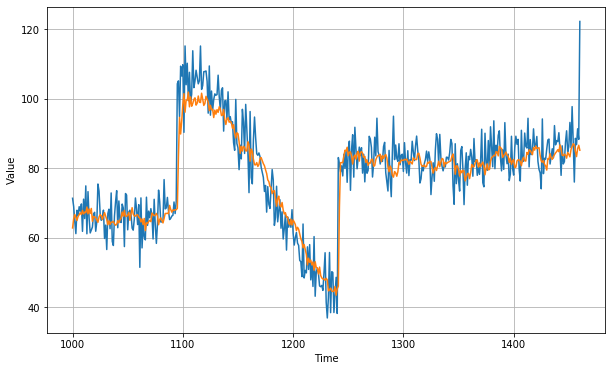

In [61]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [62]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

4.900383

## Fully Convolutional Forecasting

In [63]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))
optimizer = keras.optimizers.Adam(lr=1e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 2s 240ms/step - loss: 42.1698 - mae: 42.7348
Epoch 2/100
8/8 [==============================] - 0s 31ms/step - loss: 41.7874 - mae: 42.3290
Epoch 3/100
8/8 [==============================] - 0s 38ms/step - loss: 41.1948 - mae: 41.9344
Epoch 4/100
8/8 [==============================] - 0s 36ms/step - loss: 40.7752 - mae: 41.5100
Epoch 5/100
8/8 [==============================] - 0s 30ms/step - loss: 40.2081 - mae: 40.9796
Epoch 6/100
8/8 [==============================] - 0s 30ms/step - loss: 40.2834 - mae: 40.2333
Epoch 7/100
8/8 [==============================] - 0s 34ms/step - loss: 38.3743 - mae: 39.1041
Epoch 8/100
8/8 [==============================] - 0s 30ms/step - loss: 36.6141 - mae: 37.1633
Epoch 9/100
8/8 [==============================] - 0s 34ms/step - loss: 33.1235 - mae: 33.8624
Epoch 10/100
8/8 [==============================] - 0s 33ms/step - loss: 27.7718 - mae: 28.4693
Epoch 11/100
8/8 [==============================

[0.0001, 0.1, 0, 30]

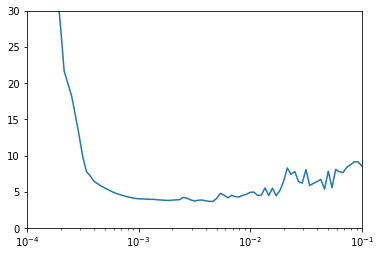

In [64]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, 30])

In [65]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
optimizer = keras.optimizers.Adam(lr=3e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
8/8 [==============================] - 2s 253ms/step - loss: 40.0740 - mae: 40.6938 - val_loss: 72.6567 - val_mae: 73.4159
Epoch 2/500
8/8 [==============================] - 0s 52ms/step - loss: 37.9815 - mae: 38.6062 - val_loss: 68.0120 - val_mae: 68.4612
Epoch 3/500
8/8 [==============================] - 0s 54ms/step - loss: 34.7697 - mae: 35.5927 - val_loss: 60.6270 - val_mae: 61.3195
Epoch 4/500
8/8 [==============================] - 0s 53ms/step - loss: 30.4835 - mae: 31.3079 - val_loss: 50.3133 - val_mae: 50.6321
Epoch 5/500
8/8 [==============================] - 0s 54ms/step - loss: 24.6251 - mae: 25.4281 - val_loss: 36.3012 - val_mae: 37.1147
Epoch 6/500
8/8 [==============================] - 0s 53ms/step - loss: 20.2775 - mae: 20.6456 - val_loss: 31.7196 - val_mae: 32.5077
Epoch 7/500
8/8 [==============================] - 0s 55ms/step - loss: 18.7948 - mae: 19.3888 - val_loss: 29.5587 - val_mae: 30.5284
Epoch 8/500
8/8 [==============================] - 0s 58ms/st

In [0]:
model = keras.models.load_model("my_checkpoint.h5")

In [0]:
cnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
cnn_forecast = cnn_forecast[split_time - window_size:-1, -1, 0]

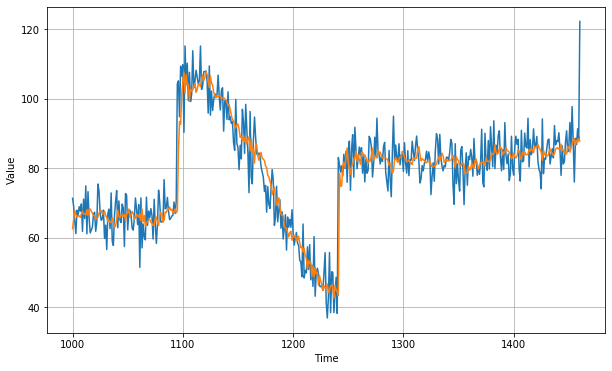

In [68]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_forecast)

In [69]:
keras.metrics.mean_absolute_error(x_valid, cnn_forecast).numpy()

4.557381